In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler,Normalizer,LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error
from scipy import stats
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import AdaBoostRegressor,RandomForestRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
import optuna
import optuna.integration.lightgbm as lgb2
import optuna.integration.xgboost as xgb2
from keras.models import Sequential
from keras.layers import Dense,Dropout,Input,AlphaDropout
from keras.regularizers import Regularizer,l2 
from collections import OrderedDict
from itertools import product
import re
#import hvplot.pandas
%matplotlib inline
import plotly.offline as pyo
pyo.init_notebook_mode()

### Objective

**We are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set.**

In [3]:
salesDF=pd.read_csv('../input/competitive-data-science-predict-future-sales/sales_train.csv')
itemsDF=pd.read_csv('../input/competitive-data-science-predict-future-sales/items.csv')
itemsCategoriesDF=pd.read_csv('../input/competitive-data-science-predict-future-sales/item_categories.csv')
shopsDF=pd.read_csv('../input/competitive-data-science-predict-future-sales/shops.csv')
testDF=pd.read_csv('../input/competitive-data-science-predict-future-sales/test.csv')

In [4]:
salesDF.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [5]:
# Cleaning shops data
# Якутск Орджоникидзе, 56
salesDF.loc[salesDF.shop_id == 0, 'shop_id'] = 57
testDF.loc[testDF.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
salesDF.loc[salesDF.shop_id == 1, 'shop_id'] = 58
testDF.loc[testDF.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
salesDF.loc[salesDF.shop_id == 10, 'shop_id'] = 11
testDF.loc[testDF.shop_id == 10, 'shop_id'] = 11

Here on analysing the shop names, we can find that the shop names encompass the city name and the category. 

For eg: **shop id 2 - Адыгея ТЦ "Мега" - Adygea mega shopping mall(English translation)**

Here Adygea is the name of the city in Russia

In [6]:
shopsDF['city']=shopsDF['shop_name'].apply(lambda x: x.split(" ")[0])
shopsDF['category']=shopsDF['shop_name'].apply(lambda x: x.split(" ")[1])

##Each SHOP_ID' in this list belongs to separate category and we use 'other' to encompass them.
for i in [0,6,9,20,21,22,46,55,57,10,11]:
    shopsDF.loc[shopsDF['shop_id']==i,'category']='other'
    
    
shopsDF.loc[shopsDF['city']=='!Якутск','city']='Якутск'

# le=LabelEncoder()
# shopsDF['city']=le.fit_transform(shopsDF['city'])
# shopsDF['category']=le.fit_transform(shopsDF['category'])

When we explore item category names we have:

For eg : **item_category_id 0 - PC  Гарнитуры/Наушники - PC Headset/Headphones**

**Hence we can separate this feature as 2 columns as main category and sub category**

In [7]:
##Splits item_category name into main category and sub category
categories=[]
sub_categories=[]

for i in itemsCategoriesDF['item_category_name'].unique():
    if len(list(i.split(" - ")))==1:
        categories.append(i.split(" - ")[0])
        sub_categories.append('other')
    else:
        categories.append(i.split(" - ")[0])
        sub_categories.append(i.split(" - ")[1])
        
itemsCategoriesDF['main_category']=categories
itemsCategoriesDF['sub_category']=sub_categories

# le=LabelEncoder()
# itemsCategoriesDF['main_category']=le.fit_transform(itemsCategoriesDF['main_category'])
# itemsCategoriesDF['sub_category']=le.fit_transform(itemsCategoriesDF['sub_category'])

Let the items categories dataframe after splitting features be merged with the items dataframe

In [8]:
itemsNewDF=pd.merge(itemsDF,itemsCategoriesDF[['item_category_id','main_category','sub_category']],on='item_category_id',how='inner')

In [9]:
salesDF=pd.merge(salesDF,itemsNewDF[['item_id','item_category_id','main_category','sub_category']],on='item_id',how='inner')
salesDF=pd.merge(salesDF,shopsDF[['shop_id','city','category']],on='shop_id',how='inner')

**Lets remove the outliers**

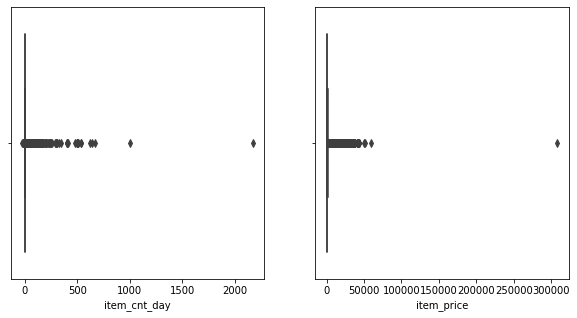

In [10]:
fig=plt.figure(figsize=(10,5))
gs=fig.add_gridspec(1,2)
ax1=fig.add_subplot(gs[0,0])
img=sns.boxplot(x=salesDF['item_cnt_day'],ax=ax1)
ax2=fig.add_subplot(gs[0,1])
img=sns.boxplot(x=salesDF['item_price'],ax=ax2)

In [11]:
pd.cut(salesDF['item_price'],10).value_counts()

(-308.981, 30797.1]     2935632
(30797.1, 61595.2]          216
(277181.9, 307980.0]          1
(61595.2, 92393.3]            0
(92393.3, 123191.4]           0
(123191.4, 153989.5]          0
(153989.5, 184787.6]          0
(184787.6, 215585.7]          0
(215585.7, 246383.8]          0
(246383.8, 277181.9]          0
Name: item_price, dtype: int64

In [12]:
salesDF.drop(salesDF[(salesDF['item_cnt_day']>200)&(salesDF['item_cnt_day']<0)].index,axis=0,inplace=True)
salesDF.drop(salesDF[salesDF['item_price']>30797].index,axis=0,inplace=True)

In [13]:
##Splits date into day,month,year format
salesDF['DateModified']=pd.to_datetime(salesDF['date'],format='%d.%m.%Y')
salesDF['year']=salesDF['DateModified'].dt.year
salesDF['month']=salesDF['DateModified'].dt.month
salesDF['date']=salesDF['DateModified'].dt.day

# Extensive EDA

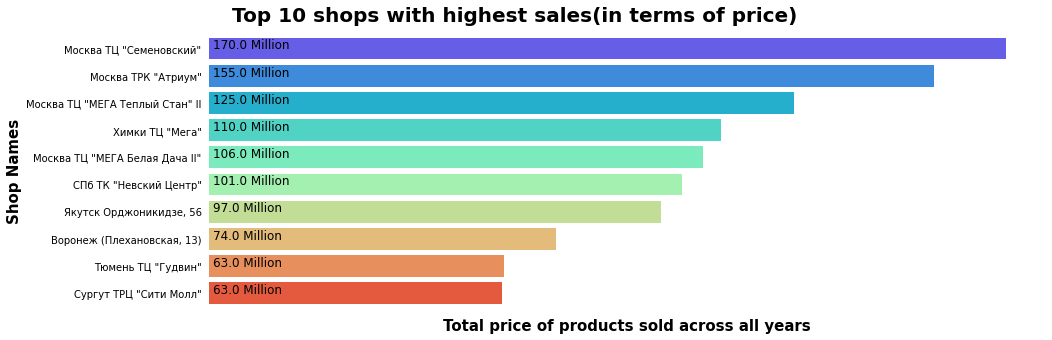

In [14]:
shopNamesDict={shopsDF['shop_id'][i]:shopsDF['shop_name'][i] for i in range(len(shopsDF))}
shopWiseSalesDF=salesDF.groupby('shop_id').agg({'item_cnt_day':'sum','item_price':'sum'})
shopWiseSalesDF=shopWiseSalesDF.sort_values(by='item_price',ascending=False)
shopWiseSalesDF.reset_index(inplace=True)
shopWiseSalesDF['item_price']=shopWiseSalesDF['item_price'].astype(float)/1000000   
shopWiseSalesDF=shopWiseSalesDF.replace({'shop_id':shopNamesDict})
fig=plt.figure(figsize=(15,5))
img=sns.barplot(data=shopWiseSalesDF[:10],y='shop_id',x='item_price',palette='rainbow')
img.set(xticklabels=[])
img.tick_params(bottom=False,left=False)
img.set_ylabel('Shop Names',fontweight='bold',fontfamily='sans-serif',fontsize=15)
img.set_xlabel('Total price of products sold across all years',fontweight='bold',fontfamily='sans-serif',fontsize=15)
img.text(5,-1,'Top 10 shops with highest sales(in terms of price)',fontfamily='sans-serif',fontweight='bold',fontsize=20)
for i in range(10):
    img.text(1,i,str(round(shopWiseSalesDF['item_price'][i],0))+' Million',fontfamily='sans-serif',fontsize=12,fontweight='medium')
sns.despine(left=True,bottom=True,right=True,top=True)

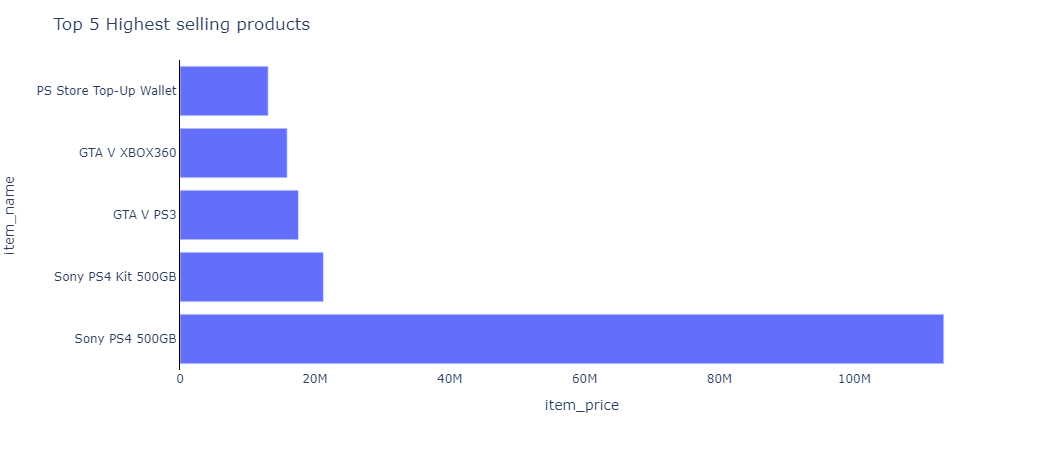

In [15]:
itemWiseSalesDF=salesDF.groupby(['item_id'],as_index=False).agg({'item_price':'sum'}).sort_values(by='item_price',ascending=False).reset_index()
itemWiseSalesDF.drop('index',axis=1,inplace=True)
#itemWiseSalesDF['item_price']=itemWiseSalesDF['item_price'].astype('float')/1000000
itemWiseSalesDF=pd.merge(itemWiseSalesDF[:10],itemsDF[['item_id','item_name']],on='item_id',how='inner')

labels=['Sony PS4 500GB','Sony PS4 Kit 500GB','GTA V PS3','GTA V XBOX360','PS Store Top-Up Wallet']

fig=px.bar(itemWiseSalesDF[:5],y='item_name',x='item_price',orientation='h')
fig.update_layout(plot_bgcolor='#fff',
                  title='Top 5 Highest selling products',
                  yaxis=dict(showline=True,linecolor='black',tickvals=[0,1,2,3,4],ticktext=labels))
fig.show()

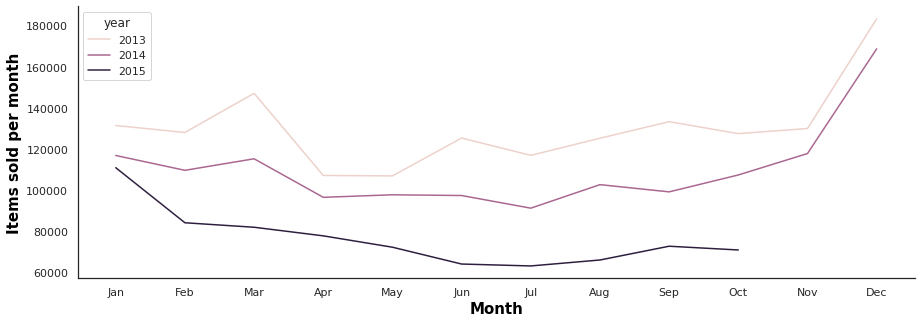

In [16]:
## Total items sold in every month across the 3 years
salesYearDF=salesDF.groupby(['year','month']).agg({'item_cnt_day':'sum'})
salesYearDF.reset_index(inplace=True)
months = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug',
          9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
salesYearDF=salesYearDF.replace({'month':months})
plt.figure(figsize=(15,5))
sns.set_context("notebook")
sns.set_style('white')
img=sns.lineplot(data=salesYearDF,x='month',y='item_cnt_day',hue='year')
img.set_xlabel('Month',fontsize=15,fontweight='bold',color='black',fontfamily='sans-serif')
img.set_ylabel('Items sold per month',fontsize=15,fontweight='bold',color='black',fontfamily='sans-serif')
sns.despine(right=True,top=True)

> **In both 2013 and 2014, there has been significant increase in sales during the months of November and December. This may be attributed due to Christmas season**

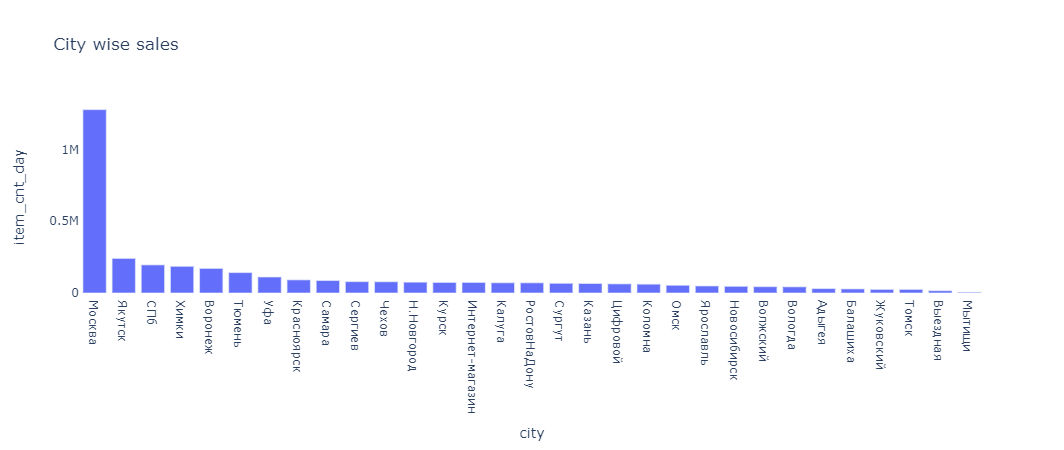

In [17]:
fig=px.bar(salesDF.groupby('city',as_index=False).agg({'item_cnt_day':'sum'}).sort_values('item_cnt_day',ascending=False),
           x='city',
           y='item_cnt_day',
          title='City wise sales')
fig.update_layout(plot_bgcolor='#fff')
fig.show()

The below function groups the dataframe based on city and identifies the top 5 categories in each city and represented in terms of percentage

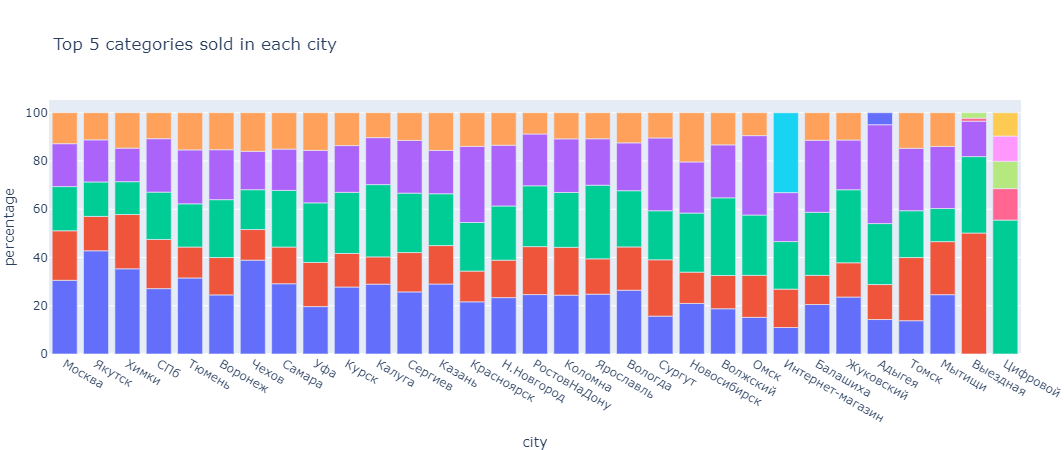

In [18]:
cityWiseSalesDF=salesDF.groupby(['city','main_category']).agg({'item_cnt_day':'sum'}).sort_values('item_cnt_day',ascending=False).reset_index()
cityWiseSalesDF=cityWiseSalesDF.groupby('city').head(5)
cityWiseSalesDF['percentage']=cityWiseSalesDF.groupby('city')['item_cnt_day'].transform(lambda x:round(x*100/x.sum(),2))
fig=px.bar(cityWiseSalesDF,x='city',y='percentage',color='main_category',title='Top 5 categories sold in each city')
fig.update_layout(margin=dict(l=0,r=0,b=0),
                 showlegend=False)
fig.show()

**Even though Moscow is the city with highest sales some categories like cinema bluray cd's and dvd's are comparatively sold more in Yakutsk city**

> **Delivery of goods(Доставка товара) as a category is found only in the city of Интернет-магазин and accounts for 30% of sales.**
> 
> **PC games and movies accountfor the majority of sale in almost all cities**

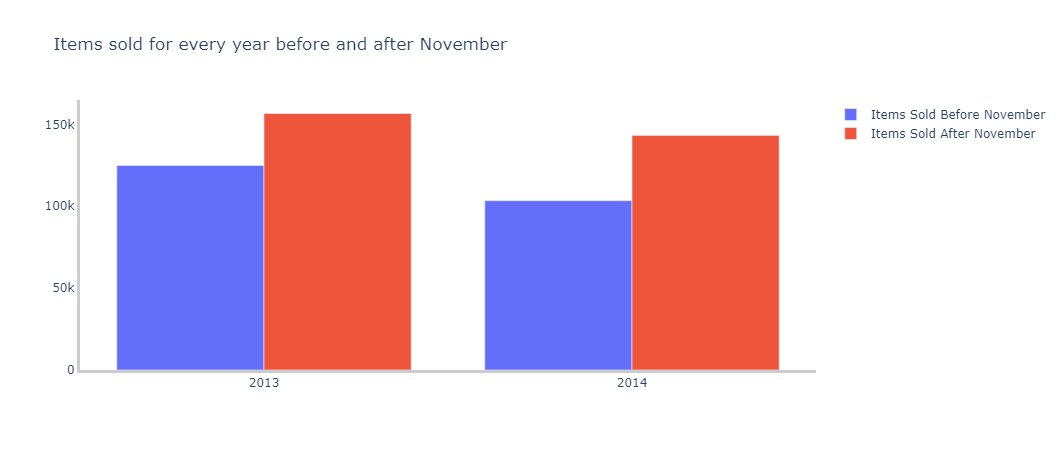

In [19]:
salesPartitionDict={2013:{'Items Sold Before November':0,'Items Sold After November':0},2014:{'Items Sold Before November':0,'Items Sold After November':0}}

for year in [2013,2014]:
    salesPartitionDict[year]['Items Sold After November']=salesYearDF[(salesYearDF['month'].isin(['Nov','Dec'])) & (salesYearDF['year']==year)]['item_cnt_day'].mean()
    salesPartitionDict[year]['Items Sold Before November']=salesYearDF[(-salesYearDF['month'].isin(['Nov','Dec'])) & (salesYearDF['year']==year)]['item_cnt_day'].mean()
    
salesPartitionDF=pd.DataFrame(salesPartitionDict).transpose()
salesPartitionDF.reset_index(inplace=True)
salesPartitionDF.rename(columns={'index':'year'},inplace=True)

data=[go.Bar(x=salesPartitionDF['year'],y=salesPartitionDF[i],name=i)for i in salesPartitionDF.columns[1:]]
layout=go.Layout(title='Items sold for every year before and after November')
fig=go.Figure(data=data,layout=layout)
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=False,
        linecolor='rgb(204, 204, 204)',
        linewidth=3,
        tickmode='linear',
        dtick=1
    ),
    yaxis=dict(
        showgrid=False,
        zeroline=False,
        showline=True,
        showticklabels=True,
        linecolor='rgb(204, 204, 204)',
        linewidth=3,
    ),
    plot_bgcolor='white'
)
fig.show()

In [20]:
dateBlockNumMonth={0:'Jan 2013',1:'Feb 2013',2:'Mar 2013',3:'Apr 2013',4:'May 2013',5:'Jun 2013',6:'Jul 2013',7:'Aug 2013',8:'Sep 2013',9:'Oct 2013',10:'Nov 2013',11:'Dec 2013',
                  12:'Jan 2014',13:'Feb 2014',14:'Mar 2014',15:'Apr 2014',16:'May 2014',17:'Jun 2014',18:'Jul 2014',19:'Aug 2014',20:'Sep 2014',21:'Oct 2014',22:'Nov 2014',23:'Dec 2014',
                  24:'Jan 2015',25:'Feb 2015',26:'Mar 2015',27:'Apr 2015',28:'May 2015',29:'Jun 2015',30:'Jul 2015',31:'Aug 2015',32:'Sep 2015',33:'Oct 2015'}
a=salesDF.groupby(['date_block_num','item_id'],as_index=False).agg({'item_cnt_day':'sum'})
monthlyHighestDict=OrderedDict()
n=0
for i in range(34):
    b=a[a['date_block_num']==i]
    b=b.sort_values(by='item_cnt_day',ascending=False)[:5]
    b.reset_index(inplace=True)
    for j in range(5):
        #item_name=itemsDF[itemsDF['item_id']==b.loc[j]['item_id']]['item_name'].values[0]
        monthlyHighestDict[n]={'month':dateBlockNumMonth[i],'item_name':str(b.loc[j]['item_id']),'count':b.loc[j]['item_cnt_day']}
        n+=1

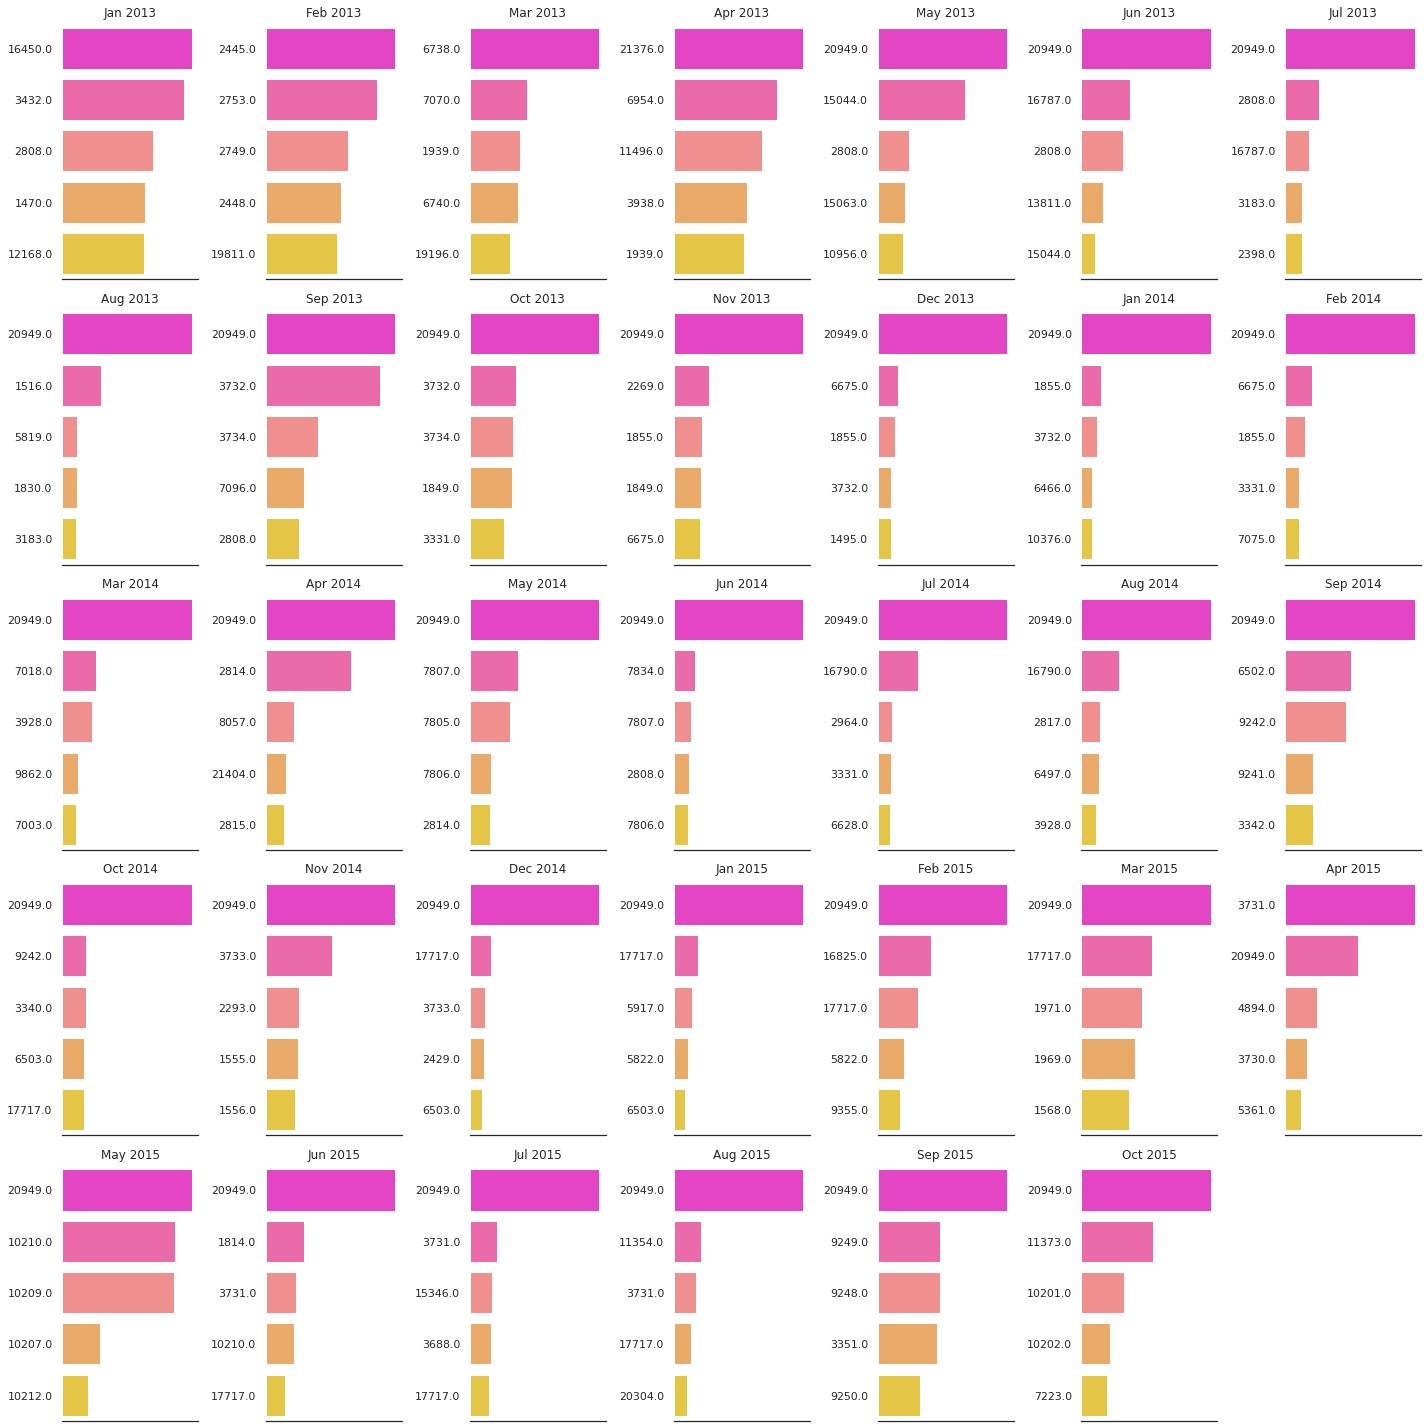

In [21]:
fig=plt.figure(figsize=(20,20))
gs=fig.add_gridspec(5,7)
monthlyHighestDF=pd.DataFrame(monthlyHighestDict).transpose()
n=0
for i in range(5):
    for j in range(7):
        if n==34:
            break
        df=monthlyHighestDF[monthlyHighestDF['month']==dateBlockNumMonth[n]]
        ax=fig.add_subplot(gs[i,j])
        img=sns.barplot(data=df,y='item_name',x='count',palette='spring',orient='h',ax=ax)
        ax.set_title(dateBlockNumMonth[n])
        img.set(xlabel=None,ylabel=None,xticks=[])
        for s in ['top','right','left']:
            ax.spines[s].set_visible(False)
        ax.tick_params(left=False)
        n=n+1
    
plt.tight_layout()

> **The mostly sold products for all months is Branded package T-shirt 1C White,Diablo III(Game), Battlefield IV, Grand Theft Auto V (GTA V), FIFA 14, Sims 4. Most of them are games for PC,XBOX and PS3.**
> 
> **For eg: Battlefield 4 has been one of the top sold products in Nov 2013,Dec 2013, Jan 2014 and Feb 2014. The release date of Battlefield 4 is 29th October 2013.**
> 
> **Similarly GTA V was released on 17th September 2013 and it was top sold products in Sep,Oct,Dec 2013 and Jan 2014. We would be wondering what happened in Nov 2013 and it was ocupied by Battlefield 4. Nov 2013 also saw higher sales of Assassin's creed 4 and Call of Duty Ghosts. But its sales faded in subsequent months.**

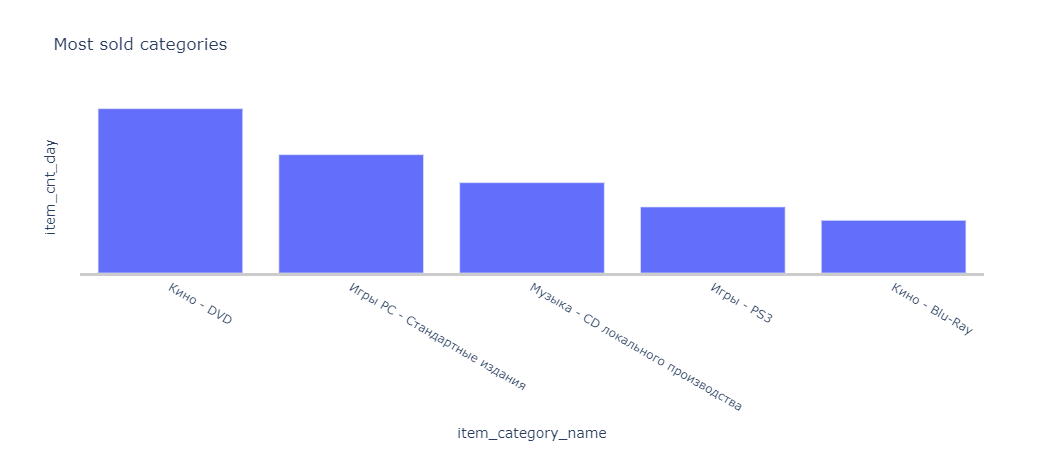

<Figure size 1080x432 with 0 Axes>

In [22]:
plt.figure(figsize=(15,6))
categoriesSalesDF=salesDF.groupby(['item_category_id'],as_index=False).agg({'item_cnt_day':'sum'})
categoriesSalesDF.reset_index(inplace=True)
categoriesSalesDF=categoriesSalesDF.sort_values(by='item_cnt_day',ascending=False)
categoriesSalesDF=pd.merge(categoriesSalesDF,itemsCategoriesDF[['item_category_name','item_category_id']],on='item_category_id',how='inner')
fig=px.bar(categoriesSalesDF[:5],x='item_category_name',y='item_cnt_day',title='Most sold categories')
fig.update_layout(plot_bgcolor='#fff',xaxis=dict(showline=True,linecolor='rgb(204, 204, 204)',linewidth=3),
                  yaxis=dict(showticklabels=False))
fig.show()

**Games CD's, Movies CD's, Music CD's are the most sold categories**

In [23]:
shopItemSalesDF=salesDF.groupby(['shop_id','item_id'],as_index=False).agg({'item_cnt_day':'sum'})
shopItemSalesDF.rename(columns={'item_cnt_day':'item_cnt'},inplace=True)
shopItemSalesDF['item_cnt']=shopItemSalesDF['item_cnt'].astype(np.int16)
shopItemSalesDF.sort_values(by='item_cnt',ascending=False,inplace=True)

In [24]:
shopTopItem=OrderedDict()
n=0
for shop in shopItemSalesDF['shop_id'].unique():
    shop_id=shop
    item_id=shopItemSalesDF[shopItemSalesDF['shop_id']==shop][:1]['item_id'].values[0]
    item_cnt=shopItemSalesDF[shopItemSalesDF['shop_id']==shop][:1]['item_cnt'].values[0]
    shopTopItem[n]={'shop_id':shop,'item_id':item_id,'item_cnt':item_cnt}
    n+=1
    
shopTopItemDF=pd.DataFrame(shopTopItem).transpose()

li=[]
for i in range(len(shopTopItemDF)):
    if shopTopItemDF.loc[i]['item_id']==20949:
        li.append('item_20949')
    else:
        li.append('others')
shopTopItemDF['category']=li

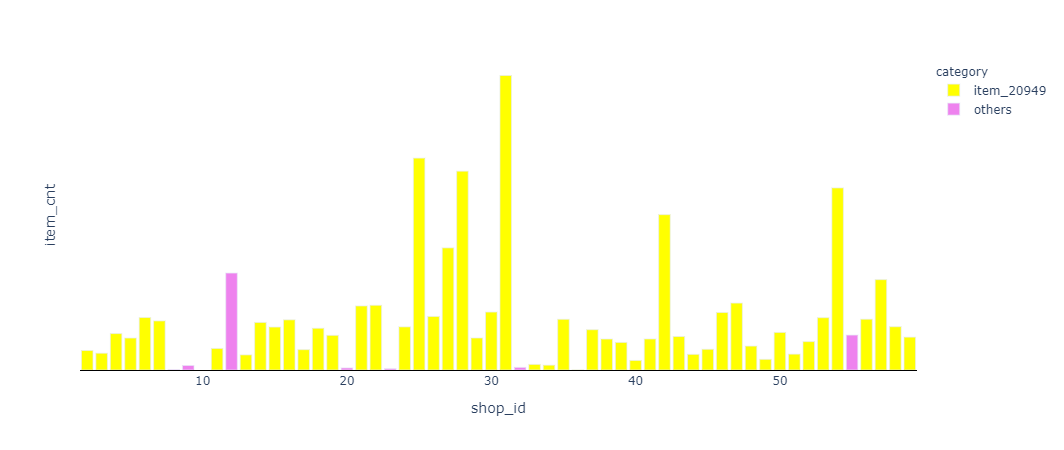

In [25]:
fig=px.bar(shopTopItemDF,x='shop_id',y='item_cnt',color='category', # if values in column category = 'item_20949' and 'others'
    color_discrete_map={
        'item_20949': 'yellow',
        'others': 'violet'
    })
fig.update_layout(plot_bgcolor='#fff',xaxis={'showline':True,'linewidth':1,'linecolor':'black'},yaxis={'showticklabels':False})
fig.show()

**For almost all shops T-Shirts is the most sold category**

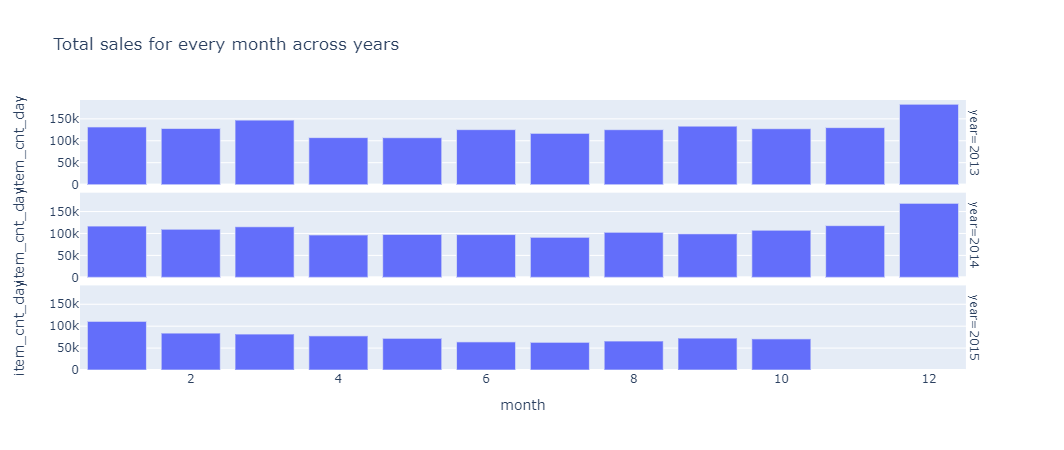

In [26]:
yearDayDF=salesDF.groupby(['year','month'],as_index=False).agg({'item_cnt_day':'sum'})
fig=px.bar(yearDayDF,x='month',y='item_cnt_day',facet_row='year',title='Total sales for every month across years')
fig.show()

> **2015 has lower sales number compared with 2013 and 2014**

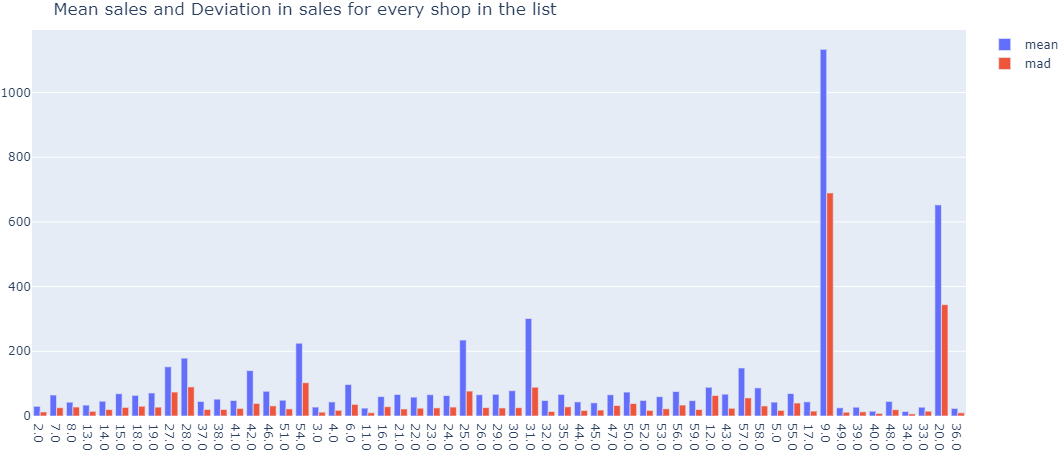

In [27]:
yearMonthDayDF=salesDF.groupby(['year','month','date','shop_id'],as_index=False).agg({'item_cnt_day':'sum','DateModified':'min'})

shopStats=OrderedDict()
n=0
for i in yearMonthDayDF['shop_id'].unique():
    mad=yearMonthDayDF[yearMonthDayDF['shop_id']==i]['item_cnt_day'].mad()
    mean=yearMonthDayDF[yearMonthDayDF['shop_id']==i]['item_cnt_day'].mean()
    max=yearMonthDayDF[yearMonthDayDF['shop_id']==i]['item_cnt_day'].max()
    shopStats[n]={'shop_id':i,'mean':mean,'max':max,'mad':mad}
    n+=1
    
shopStatsDF=pd.DataFrame(shopStats).transpose()
shopStatsDF['shop_id']=shopStatsDF['shop_id'].astype('str')
data=[go.Bar(x=shopStatsDF['shop_id'],y=shopStatsDF[i],name=i)for i in ['mean','mad']]
layout=go.Layout(title='Mean sales and Deviation in sales for every shop in the list',
                 margin=dict(l=0,r=0,b=0,t=30),
                 width=1500)
fig=go.Figure(data,layout)
fig.show()

> **Shops with higher sales are predominantly found in Moscow. Atrium Mall in Moscow(Shop id=25) has a good mean sales and lesser mean absolute deviation compared with others.**

# Categorical Encoding

We have certain columns which should be encoded like cities,shops and categories. If we apply one hot encoding then there will be numeral columns. If we apply lable encoding the information may not be correctly represented. 

So **let's group the cities and categories based on their sales. For eg Moscow city sells the most number of products. Other cities lag behind. Let's create two categories as moscow and other_cities. Now it will be easy to encode.**

In [28]:
dicCity=pd.cut(salesDF.groupby('city').agg({'item_cnt_day':'sum'})['item_cnt_day'],2,labels=['other_cities','moscow'])
shopsDF['city'].replace(dicCity,inplace=True)
salesDF['city'].replace(dicCity,inplace=True)

In [29]:
dicMainCategory=pd.cut(salesDF.groupby('main_category').agg({'item_cnt_day':'sum'})['item_cnt_day'],3,labels=['low','medium','high'])
itemsNewDF['main_category'].replace(dicMainCategory,inplace=True)
salesDF['main_category'].replace(dicMainCategory,inplace=True)

In [30]:
dicSubCategory=pd.cut(salesDF.groupby('sub_category').agg({'item_cnt_day':'sum'})['item_cnt_day'],2,labels=['medium','high'])
itemsNewDF['sub_category'].replace(dicSubCategory,inplace=True)
salesDF['sub_category'].replace(dicSubCategory,inplace=True)

In [31]:
dicCategory=pd.cut(salesDF.groupby('category').agg({'item_cnt_day':'sum'})['item_cnt_day'],3,labels=['low','medium','high'])
shopsDF['category'].replace(dicCategory,inplace=True)
salesDF['category'].replace(dicCategory,inplace=True)

In [32]:
for col in salesDF.select_dtypes('object').columns:
    le=LabelEncoder()
    salesDF[col]=le.fit_transform(salesDF[col])
    if col in itemsNewDF.columns:
        itemsNewDF[col]=le.fit_transform(itemsNewDF[col])
    elif col in shopsDF.columns:
        shopsDF[col]=le.fit_transform(shopsDF[col])

In [33]:
salesDF.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,main_category,sub_category,city,category,DateModified,year,month
0,2,0,59,22154,999.0,1.0,37,0,1,1,0,2013-01-02,2013,1
1,16,4,59,2573,249.0,1.0,55,2,0,1,0,2013-05-16,2013,5
2,26,0,59,2574,399.0,1.0,55,2,0,1,0,2013-01-26,2013,1
3,9,0,59,2574,399.0,1.0,55,2,0,1,0,2013-01-09,2013,1
4,24,1,59,2574,399.0,1.0,55,2,0,1,0,2013-02-24,2013,2


# Feature Engineering

Now we want to make sales forecast for a particular item to be sold in a particular shop for the month of 2015 November. So we are creating a dataframe with all possible combinations of month,shop_id and item_id.

In [34]:
cols=['date_block_num', 'shop_id', 'item_id'],
matrix=[]
for i in range(34):
    dup=salesDF[salesDF['date_block_num']==i]
    matrix.append(np.array(list(product([i],dup['shop_id'].unique(),dup['item_id'].unique())), dtype = np.int16))
    
matrix=pd.DataFrame(np.vstack(matrix))
matrix.rename(columns={0:'date_block_num',1:'shop_id',2:'item_id'},inplace=True)

matrix["date_block_num"] = matrix["date_block_num"].astype(np.int8)
matrix["shop_id"] = matrix["shop_id"].astype(np.int8)
matrix["item_id"] = matrix["item_id"].astype(np.int16)

matrix.sort_values(by=['date_block_num', 'shop_id', 'item_id'],inplace=True)
matrix.reset_index(inplace=True)
matrix.drop('index',axis=1,inplace=True)

After creating the dataframe with month,shop_id and item_id we will merge this dataframe with the monthly sales of a item sold in a particular shop calculated from the sales dataframe

In [35]:
group=salesDF.groupby(["date_block_num", "shop_id", "item_id"],as_index=False).agg({'item_cnt_day':'sum'})
group.rename(columns={'item_cnt_day':'item_cnt_month'},inplace=True)
matrix=pd.merge(matrix,group,on=['date_block_num', 'shop_id', 'item_id'],how='left')
matrix['item_cnt_month']=matrix['item_cnt_month'].fillna(0).astype(np.float16)
matrix['item_cnt_month']=matrix['item_cnt_month'].clip(0,20)

In [36]:
group=salesDF.groupby(['date_block_num','shop_id','item_id'],as_index=False).agg({'item_price':'sum'})
group.rename(columns={'item_price':'item_price_month'},inplace=True)
matrix=pd.merge(matrix,group,on=['date_block_num','shop_id','item_id'],how='left')
matrix['item_price_month']=matrix['item_price_month'].fillna(0).astype(np.float16)

In [37]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_price_month
0,0,2,19,0.0,0.0
1,0,2,27,1.0,2500.0
2,0,2,28,0.0,0.0
3,0,2,29,0.0,0.0
4,0,2,32,0.0,0.0


Lets concat the test dataframe to our matrix dataframe. November 2015 is indicated by date block num 34

In [38]:
testDF["date_block_num"] = 34
testDF["date_block_num"] = testDF["date_block_num"].astype(np.int8)
testDF["shop_id"] = testDF.shop_id.astype(np.int8)
testDF["item_id"] = testDF.item_id.astype(np.int16)

In [39]:
matrix=pd.concat([matrix,testDF.drop('ID',axis=1)],ignore_index=True,sort=False,keys=['date_block_num', 'shop_id', 'item_id'])
matrix.fillna(0,inplace=True)

matrix=pd.merge(matrix,itemsNewDF[['item_id','item_category_id','main_category','sub_category']],on='item_id',how='left')
matrix=pd.merge(matrix,shopsDF[['shop_id','city','category']],on='shop_id',how='left')

In [40]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_price_month,item_category_id,main_category,sub_category,city,category
0,0,2,19,0.0,0.0,40,0,0,1,0
1,0,2,27,1.0,2500.0,19,0,1,1,0
2,0,2,28,0.0,0.0,30,0,0,1,0
3,0,2,29,0.0,0.0,23,0,1,1,0
4,0,2,32,0.0,0.0,40,0,0,1,0


In [ ]:
import gc
del [salesDF,itemsDF,itemsCategoriesDF,itemsNewDF,shopsDF]
gc.collect()

Now we will create the **lag columns**

**item_cnt_month_lag_1** indicates the **no of items sold in that particular shop in the previous month** and similary

**item_cnt_month_lag_12** indicates the **no of items sold in that particular shop 12 months before**

In [41]:
df=matrix
for col in ['item_cnt_month']:
    tmp = df[["date_block_num", "shop_id","item_id",col ]]
    for i in [1,2,3,12]:
        shifted = tmp.copy()
        shifted.columns = ["date_block_num", "shop_id", "item_id", col + "_lag_"+str(i)]
        shifted.date_block_num = shifted.date_block_num + i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')

matrix=df

In [42]:
group=matrix.groupby(['date_block_num'],as_index=False).agg({'item_cnt_month':'mean'}).rename(columns={'item_cnt_month':'avg_item_cnt_month'})
matrix = pd.merge(matrix, group, on = ["date_block_num"], how = "left")
matrix['avg_item_cnt_month']=matrix['avg_item_cnt_month'].astype(np.float16)

df=matrix[['date_block_num','shop_id','item_id','avg_item_cnt_month']]
shifted=df.copy()
shifted.columns=['date_block_num','shop_id','item_id','prev_month_avg_item_cnt']
shifted['date_block_num']=shifted['date_block_num']+1

matrix=pd.merge(matrix,shifted,on=['date_block_num','shop_id','item_id'],how='left')
matrix.drop('avg_item_cnt_month',axis=1,inplace=True)

In [43]:
group=matrix.groupby(['date_block_num','shop_id'],as_index=False).agg({'item_cnt_month':'mean'}).rename(columns={'item_cnt_month':'shop_avg_cnt_month'})
group['shop_avg_cnt_month']=group['shop_avg_cnt_month'].astype(np.float16)
matrix=pd.merge(matrix,group,on=['date_block_num','shop_id'],how='left')

df=matrix

tmp=df[['date_block_num', 'shop_id','item_id','shop_avg_cnt_month']]

for i in [1,2,3,12]:
    shifted=tmp.copy()
    shifted.columns=['date_block_num','shop_id','item_id','shop_avg_cnt_month_'+'_lag_'+str(i)]
    shifted['date_block_num']=shifted['date_block_num']+i
    df=pd.merge(df,shifted,on=['date_block_num','shop_id','item_id'],how='left')
        
matrix=df
matrix.drop('shop_avg_cnt_month',axis=1,inplace=True)

In [44]:
group=matrix.groupby(['date_block_num','item_id'],as_index=False).agg({'item_cnt_month':'mean'}).rename(columns={'item_cnt_month':'item_avg_cnt_month'})
group['item_avg_cnt_month']=group['item_avg_cnt_month'].astype(np.float16)
matrix=pd.merge(matrix,group,on=['date_block_num','item_id'],how='left')

df=matrix

tmp=df[['date_block_num', 'shop_id','item_id','item_avg_cnt_month']]
for i in [1,2,3,12]:
    shifted=tmp.copy()
    shifted.columns=['date_block_num','shop_id','item_id','item_avg_cnt_month_'+'_lag_'+str(i)]
    shifted['date_block_num']=shifted['date_block_num']+i
    df=pd.merge(df,shifted,on=['date_block_num','shop_id','item_id'],how='left')
        
matrix=df
matrix.drop('item_avg_cnt_month',axis=1,inplace=True)

In [ ]:
import gc
del [group,tmp,shifted,df,dup]
gc.collect()

In [45]:
group=matrix.groupby(['date_block_num','main_category'],as_index=False).agg({'item_cnt_month':'mean'}).rename(columns={'item_cnt_month':'item_category_avg_cnt_month'})
group['item_category_avg_cnt_month']=group['item_category_avg_cnt_month'].astype(np.float16)
matrix=pd.merge(matrix,group,on=['date_block_num','main_category'],how='left')

df=matrix
for col in ['item_category_avg_cnt_month']:
    tmp=df[['date_block_num','shop_id','item_id',col]]
    for i in [1,2,12]:
        shifted=tmp.copy()
        shifted.columns=['date_block_num','shop_id','item_id',col+'_lag_'+str(i)]
        shifted['date_block_num']=shifted['date_block_num']+i
        df=pd.merge(df,shifted,on=['date_block_num','shop_id','item_id'],how='left')
        
matrix=df
matrix.drop('item_category_avg_cnt_month',axis=1,inplace=True)

In [46]:
group=matrix.groupby(['date_block_num','item_id','main_category','sub_category'],as_index=False).agg({'item_cnt_month':'mean'}).rename(columns={'item_cnt_month':'item_categories_avg_cnt_month'})
group['item_categories_avg_cnt_month']=group['item_categories_avg_cnt_month'].astype(np.float16)
matrix=pd.merge(matrix,group,on=['date_block_num','item_id','main_category','sub_category'],how='left')

df=matrix
for col in ['item_categories_avg_cnt_month']:
    tmp=df[['date_block_num','shop_id','item_id',col]]
    for i in [1,2,3,12]:
        shifted=tmp.copy()
        shifted.columns=['date_block_num','shop_id','item_id',col+'_lag_'+str(i)]
        shifted['date_block_num']=shifted['date_block_num']+i
        df=pd.merge(df,shifted,on=['date_block_num','shop_id','item_id'],how='left')
        
matrix=df
matrix.drop('item_categories_avg_cnt_month',axis=1,inplace=True)

In [ ]:
del [group,tmp,shifted,df]
gc.collect()

Since mostly the lag count for the first three months would be null, lets remove the information pertaining to those months from the dataframe.

# Preparing the data for modelling

In [48]:
matrix=matrix[matrix['date_block_num']>3]

In [49]:
##Filling nan's with zero
for col in matrix.columns:
    if ('lag' in col) & (matrix[col].isnull().any()):
        matrix[col].fillna(0,inplace=True)
        
matrix['prev_month_avg_item_cnt'].fillna(0,inplace=True)

After building the model and finding feature importance this 'item_price_month' was the most important feature. But this was causing overfitting problems and hence this column has been removed.

In [50]:
matrix.drop('item_price_month',axis=1,inplace=True)

In [51]:
x_train = matrix[matrix['date_block_num'] < 33].drop(['item_cnt_month'], axis=1)
y_train = matrix[matrix['date_block_num'] < 33]['item_cnt_month']
x_cv = matrix[(matrix['date_block_num'] == 33)].drop(['item_cnt_month'], axis=1)
y_cv = matrix[(matrix['date_block_num'] == 33)]['item_cnt_month']
x_test = matrix[matrix['date_block_num'] == 34].drop(['item_cnt_month'], axis=1)

Since we have a large dataframe lets randomly select 30,000 samples from each month for building our baseline model.

In [52]:
df2=matrix
df2=df2.drop(df2.index[0:],axis=0) ## We are duplicating the matrix and removing the rows and appending samples for each month
for i in x_train['date_block_num'].unique():
    sampleDF=matrix[matrix['date_block_num']==i].sample(n=30000,replace=False)
    df2=df2.append(sampleDF,ignore_index=True)
    
df2=df2.sample(frac=1)
df2.reset_index(inplace=True)
df2.drop('index',axis=1,inplace=True)
x_train_baseline=df2.drop('item_cnt_month',axis=1)
y_train_baseline=df2['item_cnt_month']

# LGBM

Initially we fit a simple model to our resampled data and make predictions. 

Then we calculate the feature importance and consider the top 20 features for making predictions in our tuned model.

In [ ]:
lgbmBaseline=lgb.LGBMRegressor(objective='regression',
                              boosting_type='gbdt',
                              n_estimators=500)
lgbmBaseline.fit(x_train_baseline,y_train_baseline)
lgbmBaselinePred=lgbmBaseline.predict(x_cv)
print(mean_squared_error(lgbmBaselinePred,y_cv))
#predLgbmTestBaseline=lgbmBaseline.predict(x_test)

In [ ]:
featureImportanceLgbmDF=pd.DataFrame(sorted(zip(lgbmBaseline.feature_importances_,x_train_baseline.columns)),columns=['values','features'])
featuresLgbm=list(featureImportanceLgbmDF[featureImportanceLgbmDF['values']>featureImportanceLgbmDF['values'].median()]['features'].values) ##selecting features above mean lgbm feature score
sns.barplot(y='features',x='values',data=featureImportanceLgbmDF[-20:])
#featuresLgbm=featureImportanceLgbmDF['features'][-15:].values

In [53]:
x_train_lgbm=x_train
x_cv_lgbm=x_cv
x_test_lgbm=x_test

In [54]:
#x_train_lgbm,x_test_lgbm,y_train_lgbm,y_test_lgbm=train_test_split(x_train,y_train,test_size=0.3)
def optimize(trial):
    params={
        'objective':'regression',
        'num_leaves':trial.suggest_int('num_leaves',2,256),
        'feature_fraction':trial.suggest_uniform('feature_fraction',0.4,1.0),
        'boosting_type':'gbdt',
        'reg_alpha':trial.suggest_uniform('alpha',1,10),
        'reg_lambda':trial.suggest_uniform('lambda',1,10),
        'learning_rate':trial.suggest_uniform('learning_rate',0.1,1),
        'subsample':trial.suggest_uniform('subsample',0,1),
        'n_estimators':trial.suggest_int('n_estimators',200,1000),
        'min_data_in_leaf':trial.suggest_int('min_data_in_leaf',20,100)
    }
    model=lgb.LGBMRegressor(**params)
    model.fit(x_train_lgbm,y_train,eval_set=[(x_cv_lgbm,y_cv)],early_stopping_rounds=30,verbose=0)
    pred=model.predict(x_cv_lgbm)
    rmse=mean_squared_error(pred,y_cv)
    return rmse
study=optuna.create_study(direction='minimize')
study.optimize(optimize,n_trials=10)
print('Best Trail: ',study.best_trial.params)

[I 2022-06-01 12:56:30,435] A new study created in memory with name: no-name-0e3d1e2e-62ae-4079-abbf-44ba630badf8


[LightGBM] [Warning] feature_fraction is set=0.9962761725101693, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9962761725101693
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43


[I 2022-06-01 12:57:09,678] Trial 0 finished with value: 0.8553054002087993 and parameters: {'num_leaves': 34, 'feature_fraction': 0.9962761725101693, 'alpha': 1.7172478904583461, 'lambda': 5.568901565872753, 'learning_rate': 0.21095442358921687, 'subsample': 0.9397304142510925, 'n_estimators': 273, 'min_data_in_leaf': 43}. Best is trial 0 with value: 0.8553054002087993.


[LightGBM] [Warning] feature_fraction is set=0.5516936348149871, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5516936348149871
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2022-06-01 12:57:42,361] Trial 1 finished with value: 0.8650032818947806 and parameters: {'num_leaves': 168, 'feature_fraction': 0.5516936348149871, 'alpha': 2.056027239903809, 'lambda': 2.424105403340349, 'learning_rate': 0.3841581002103337, 'subsample': 0.05659378482437316, 'n_estimators': 507, 'min_data_in_leaf': 27}. Best is trial 0 with value: 0.8553054002087993.


[LightGBM] [Warning] feature_fraction is set=0.5344889649973636, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5344889649973636
[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67


[I 2022-06-01 12:58:21,198] Trial 2 finished with value: 0.8934517846276024 and parameters: {'num_leaves': 152, 'feature_fraction': 0.5344889649973636, 'alpha': 7.404153006675711, 'lambda': 3.1865993820994336, 'learning_rate': 0.7099143438693427, 'subsample': 0.5429799146535701, 'n_estimators': 668, 'min_data_in_leaf': 67}. Best is trial 0 with value: 0.8553054002087993.


[LightGBM] [Warning] feature_fraction is set=0.7451601824364404, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7451601824364404
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2022-06-01 12:58:51,683] Trial 3 finished with value: 0.854905441266188 and parameters: {'num_leaves': 97, 'feature_fraction': 0.7451601824364404, 'alpha': 8.799576704760195, 'lambda': 6.2247091580120495, 'learning_rate': 0.3618232035890192, 'subsample': 0.39385259725841437, 'n_estimators': 806, 'min_data_in_leaf': 100}. Best is trial 3 with value: 0.854905441266188.


[LightGBM] [Warning] feature_fraction is set=0.73062085627557, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.73062085627557
[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65


[I 2022-06-01 12:59:20,802] Trial 4 finished with value: 0.9670004967563949 and parameters: {'num_leaves': 159, 'feature_fraction': 0.73062085627557, 'alpha': 6.072044150577662, 'lambda': 6.262790660308832, 'learning_rate': 0.8892667166119119, 'subsample': 0.9114464547169475, 'n_estimators': 789, 'min_data_in_leaf': 65}. Best is trial 3 with value: 0.854905441266188.


[LightGBM] [Warning] feature_fraction is set=0.9172396479054987, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9172396479054987
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56


[I 2022-06-01 12:59:46,318] Trial 5 finished with value: 0.905268820553761 and parameters: {'num_leaves': 169, 'feature_fraction': 0.9172396479054987, 'alpha': 1.6679712210290143, 'lambda': 9.035814485221904, 'learning_rate': 0.8012480050166038, 'subsample': 0.8223164118568125, 'n_estimators': 613, 'min_data_in_leaf': 56}. Best is trial 3 with value: 0.854905441266188.


[LightGBM] [Warning] feature_fraction is set=0.5119698227843441, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5119698227843441
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87


[I 2022-06-01 13:00:19,565] Trial 6 finished with value: 0.9826510009544333 and parameters: {'num_leaves': 209, 'feature_fraction': 0.5119698227843441, 'alpha': 6.85322812881234, 'lambda': 4.033657621419541, 'learning_rate': 0.993518577077907, 'subsample': 0.07816622491508063, 'n_estimators': 873, 'min_data_in_leaf': 87}. Best is trial 3 with value: 0.854905441266188.


[LightGBM] [Warning] feature_fraction is set=0.8427851180395245, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8427851180395245
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31


[I 2022-06-01 13:00:41,778] Trial 7 finished with value: 0.8977443155300168 and parameters: {'num_leaves': 50, 'feature_fraction': 0.8427851180395245, 'alpha': 4.046327436087578, 'lambda': 4.491623324589552, 'learning_rate': 0.9730100301184934, 'subsample': 0.6395727581133533, 'n_estimators': 636, 'min_data_in_leaf': 31}. Best is trial 3 with value: 0.854905441266188.


[LightGBM] [Warning] feature_fraction is set=0.8597820964231944, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8597820964231944
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61


[I 2022-06-01 13:01:22,662] Trial 8 finished with value: 0.8403062427489191 and parameters: {'num_leaves': 19, 'feature_fraction': 0.8597820964231944, 'alpha': 1.6405344954396741, 'lambda': 2.6841550550975724, 'learning_rate': 0.6484666362127951, 'subsample': 0.8020489536587889, 'n_estimators': 859, 'min_data_in_leaf': 61}. Best is trial 8 with value: 0.8403062427489191.


[LightGBM] [Warning] feature_fraction is set=0.49945260207796416, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49945260207796416
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2022-06-01 13:01:54,318] Trial 9 finished with value: 0.9276453820806292 and parameters: {'num_leaves': 219, 'feature_fraction': 0.49945260207796416, 'alpha': 8.35835844562305, 'lambda': 8.695953016220436, 'learning_rate': 0.7301549365178795, 'subsample': 0.059086617312239964, 'n_estimators': 322, 'min_data_in_leaf': 25}. Best is trial 8 with value: 0.8403062427489191.


Best Trail:  {'num_leaves': 19, 'feature_fraction': 0.8597820964231944, 'alpha': 1.6405344954396741, 'lambda': 2.6841550550975724, 'learning_rate': 0.6484666362127951, 'subsample': 0.8020489536587889, 'n_estimators': 859, 'min_data_in_leaf': 61}


In [55]:
lgbrEstimator=lgb.LGBMRegressor(**study.best_trial.params)
lgbrEstimator.fit(x_train_lgbm,y_train)
predLgbmCV=lgbrEstimator.predict(x_cv_lgbm)
print(mean_squared_error(predLgbmCV,y_cv))
predLgbTest=lgbrEstimator.predict(x_test_lgbm)
predLgbTest=predLgbTest.clip(0,20)

[LightGBM] [Warning] lambda_l2 is set with lambda=2.6841550550975724, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6841550550975724
[LightGBM] [Warning] feature_fraction is set=0.8597820964231944, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8597820964231944
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61
1.0779540407877874


# Model Explainability

**SHAP values (SHapley Additive exPlanations) is used to explain the predictions made by your model.**

**SHAP shows the contribution or the importance of each feature on the prediction of the model, it does not evaluate the quality of the prediction itself.**

In [56]:
import shap

explainer(data) ---> Returns data,base_values,shap_values

data - The original data

base_values - The expected value of the target or the mean target value from the data

shap_values - SHAP values for each sample

explainer.shap_values ---> Returns only the shap values


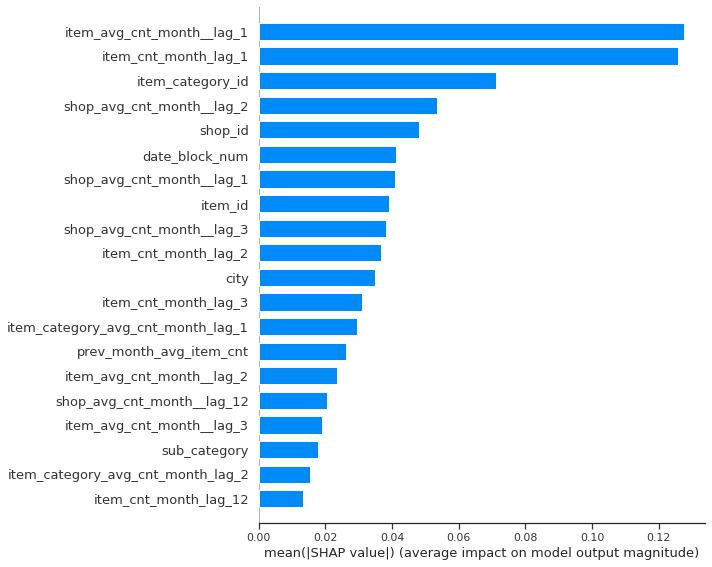

In [57]:
shap_values=shap.TreeExplainer(lgbrEstimator).shap_values(x_cv_lgbm)
shap.summary_plot(shap_values,x_cv_lgbm,plot_type='bar')

From the above plot it evident that **item_avg_cnt_month_lag,item_cnt_month_lag,shop_av_cnt_month_lag** features have better predicting power compared with other variables. This prediction is also meaningful because previous month's sales is a good indicator for sales in forecoming months. 

Another point to be noted is **sales one month before(i.e last month) is more detrimental compared with other variables**

The below plot is similar to a summary bar plot but this is more interpretable.

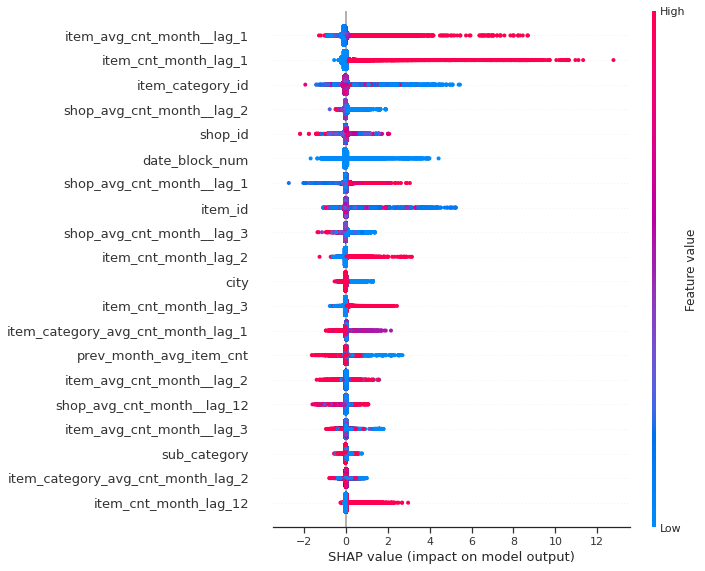

In [58]:
shap.summary_plot(shap_values,x_cv_lgbm,feature_names=x_cv_lgbm.columns)

> **The first 3 features indicates that higher items sold in the previous month means more items would be sold in the coming months.**

> **The plot indicates that lower the item id better would be the average sales. We can confirm this conclusion from pdp plots.**

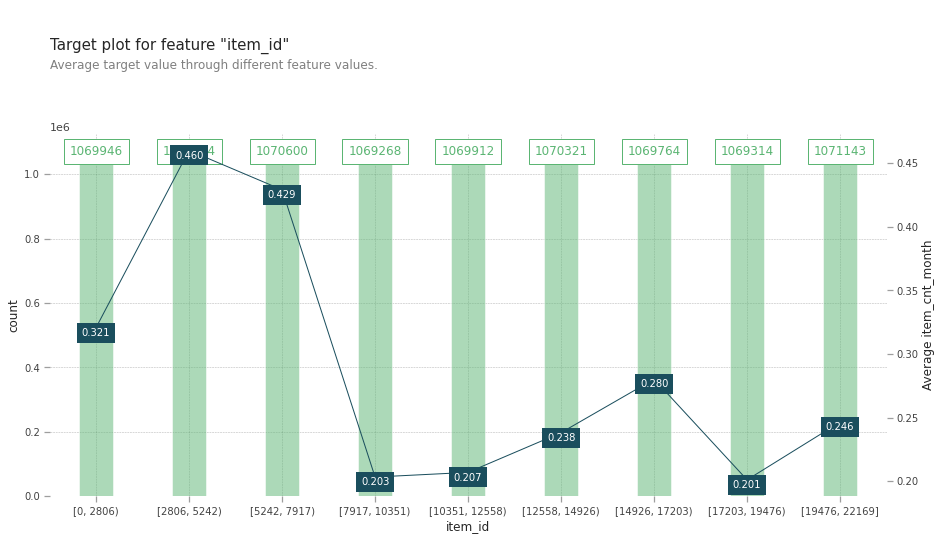

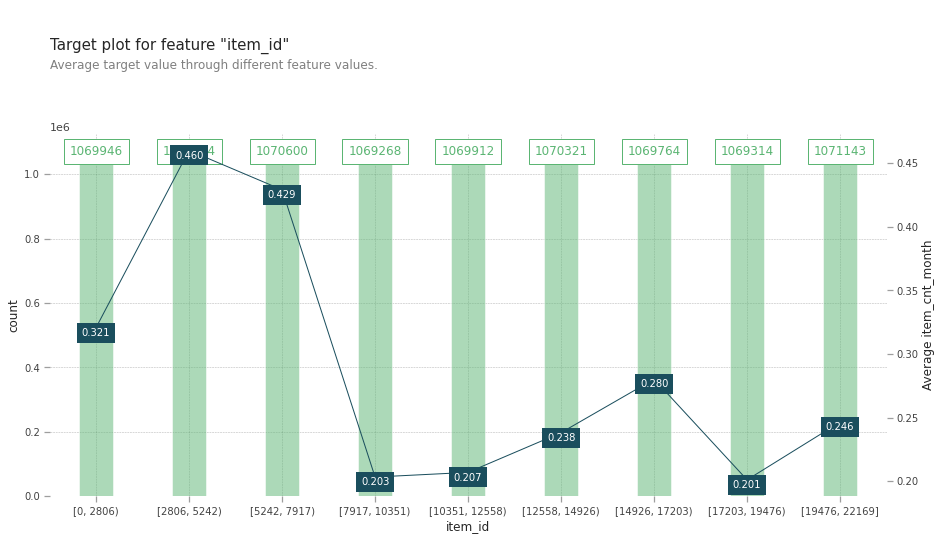

In [59]:
from pdpbox import info_plots
fig=info_plots.target_plot(df=matrix,feature='item_id',feature_name='item_id',target='item_cnt_month')
fig[0]

> **Lower item id's have better average item count per month confirming our inference from shap plot.**


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


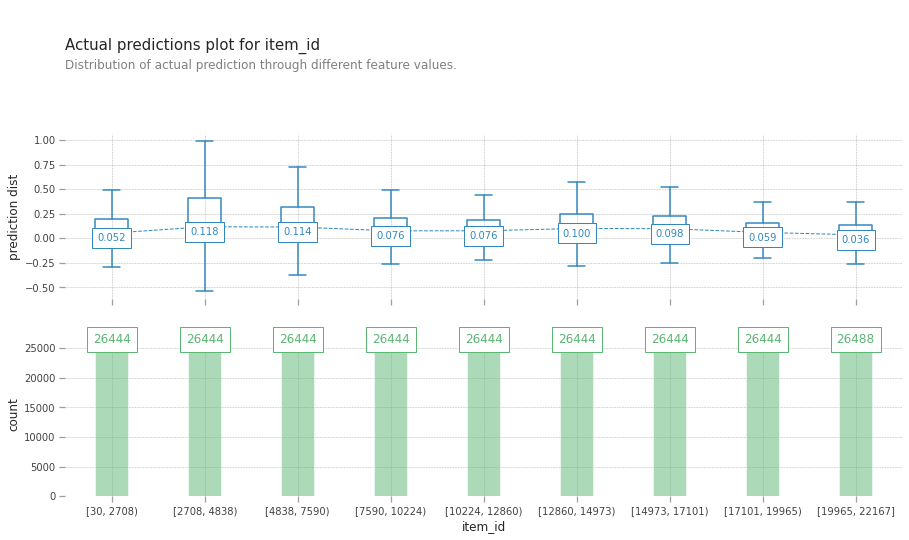

In [60]:
info_plots.actual_plot(lgbrEstimator,x_cv_lgbm,feature='item_id',feature_name='item_id');

The pattern of predictions is maintained i.e compared with other item id's 2708-4838 item id's have more items sold. But the predicted count varies significantly from actual count.

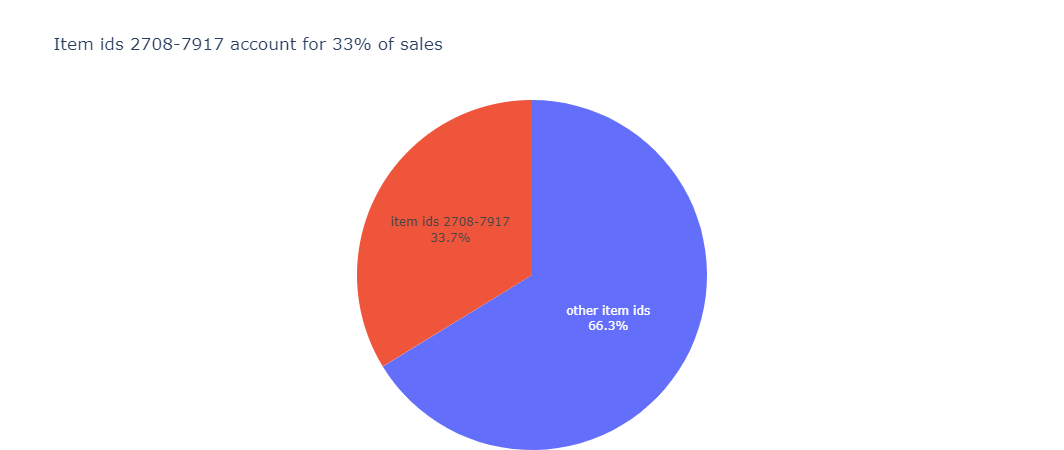

In [61]:
salesA=salesDF[(salesDF['item_id']>2708)&(salesDF['item_id']<7917)]['item_cnt_day'].sum()
salesB=salesDF[(salesDF['item_id']<2708)|(salesDF['item_id']>7917)]['item_cnt_day'].sum()
salesValues=[salesA,salesB]
salesNames=['item ids 2708-7917','other item ids']
fig=px.pie(names=salesNames,values=salesValues,title='Item ids 2708-7917 account for 33% of sales')
fig.update_layout(margin=dict(l=0,r=0,b=0),showlegend=False)
fig.update_traces(textinfo='label+percent')

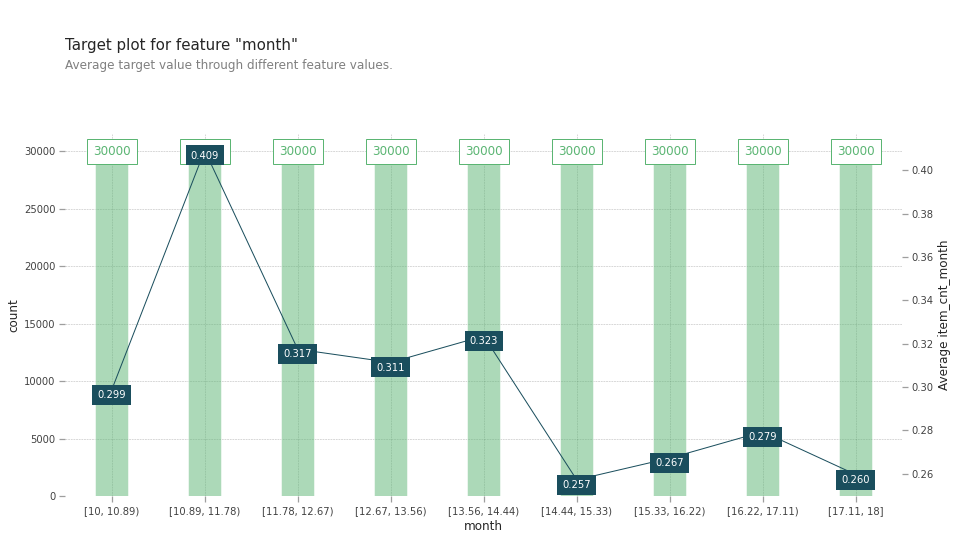

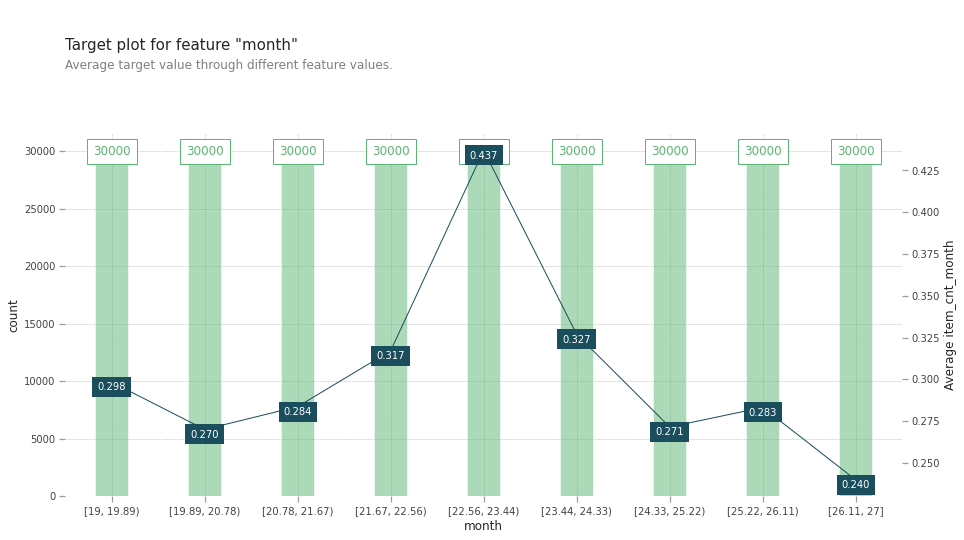

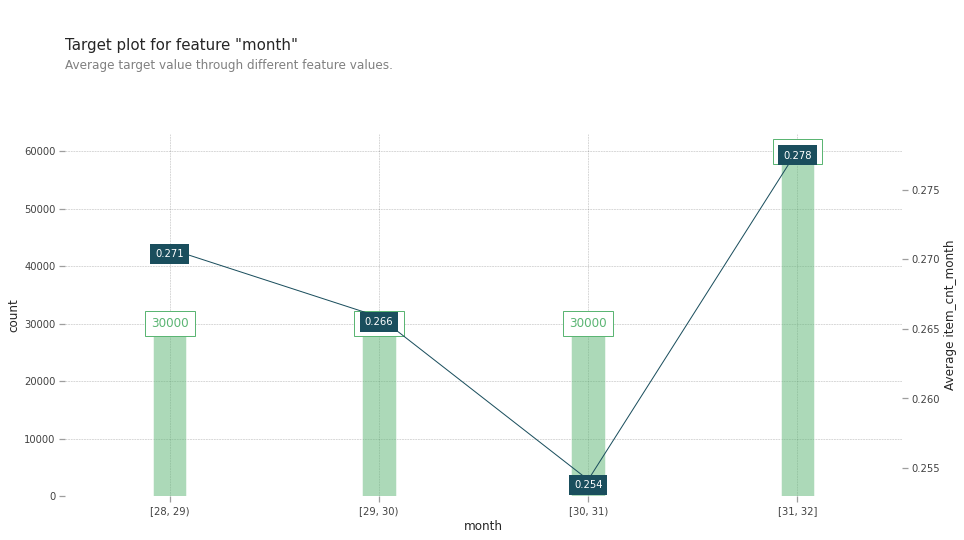

In [62]:
ax1=info_plots.target_plot(df=df2[(df2['date_block_num']>=10) & (df2['date_block_num']<19)],feature='date_block_num',feature_name='month',target='item_cnt_month')
ax2=info_plots.target_plot(df=df2[(df2['date_block_num']>=19) & (df2['date_block_num']<28)],feature='date_block_num',feature_name='month',target='item_cnt_month')
ax2=info_plots.target_plot(df=df2[df2['date_block_num']>=28],feature='date_block_num',feature_name='month',target='item_cnt_month')

# XGBOOST

In [ ]:
xgbBaseline=xgb.XGBRegressor(objective='reg:squaredlogerror',
                            eval_metric='rmse',
                            booster='gbtree',
                            n_estimators=200)
xgbBaseline.fit(x_train_baseline,y_train_baseline)
predXgbBaseline=xgbBaseline.predict(x_cv)
print(mean_squared_error(predXgbBaseline,y_cv))

In [ ]:
featureImportanceXgbDF=pd.DataFrame(sorted(zip(xgbBaseline.feature_importances_,x_train_baseline.columns)),columns=['values','features'])
featuresXgb=featureImportanceXgbDF[featureImportanceXgbDF['values']>=featureImportanceXgbDF['values'].median()]['features']
sns.barplot(x='values',y='features',data=featureImportanceXgbDF[-15:])

In [63]:
x_train_xgb=x_train
x_cv_xgb=x_cv
x_test_xgb=x_test

In [ ]:
def optimize(trial):
    params={
        'objective':'reg:squaredlogerror',
        'eval_metric':'rmse',
        'booster':'gbtree',
        'alpha':trial.suggest_loguniform('alpha',1e-8,1),
        'lambda':trial.suggest_loguniform('lambda',1e-8,1),
        'max_depth':trial.suggest_int('max_depth',1,10),
        'learning_rate':trial.suggest_uniform('learning_rate',0.001,1),
        'subsample':trial.suggest_uniform('subsample',0,1),
        'n_estimators':trial.suggest_int('n_estimators',10,300)
    }
    model=xgb.XGBRegressor(**params)
    model.fit(x_train_xgb,y_train,eval_set=[(x_cv_xgb,y_cv)],early_stopping_rounds=30)
    pred=model.predict(x_cv_xgb)
    rmse=mean_squared_error(pred,y_cv)
    return rmse
study=optuna.create_study(direction='minimize')
study.optimize(optimize,n_trials=10)
print(study.best_trial.params)

In [65]:
xgbBestParams=study.best_trial.params
xgbBestParams.update({'objective':'reg:squaredlogerror',
           'eval_metric':'rmse',
           'booster':'gbtree'})

In [66]:
#xgbReg=xgb.XGBRegressor(**study.best_trial.params)
xgbReg=xgb.XGBRegressor(**xgbBestParams)
xgbReg.fit(x_train_xgb,y_train)
predXgbCV=xgbReg.predict(x_cv_xgb)
print(mean_squared_error(predXgbCV,y_cv))
predXgbTest=xgbReg.predict(x_test_xgb)
predXgbTest=predXgbTest.clip(0,20)

0.9268171


### CATBOOST

In [67]:
x_train_cat=x_train
x_cv_cat=x_cv
x_test_cat=x_test

In [88]:
def optimize(trial):
    params={
        'depth': trial.suggest_int('depth', 4, 8),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',10,100),
        'eval_metric':'RMSE',
        'loss_function':'RMSE',
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg',5,20),
        'colsample_bylevel':trial.suggest_uniform('colsample_bylevel',0.5,1),
        'learning_rate':trial.suggest_uniform('learning_rate',0.0001,1),
        'subsample':trial.suggest_uniform('subsample',0.5,1),
        'iterations':trial.suggest_int('iterations',100,1000)
    }
    model=CatBoostRegressor(**params)
    model.fit(x_train_cat,y_train.astype('float'),eval_set=[(x_cv_cat,y_cv.astype('float'))],early_stopping_rounds=30,verbose=100)
    pred=model.predict(x_cv_cat)
    rmse=mean_squared_error(pred,y_cv.astype('float'))
    return rmse
study=optuna.create_study(direction='minimize')
study.optimize(optimize,n_trials=10)
print(study.best_trial.params)

[I 2022-06-01 15:49:48,478] A new study created in memory with name: no-name-a7de286c-fd84-40ba-84dd-dcb3360f6aa2
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 0.9909648	test: 0.9910827	best: 0.9910827 (0)	total: 1.44s	remaining: 22m 58s
100:	learn: 0.8652676	test: 0.9440805	best: 0.9338538 (92)	total: 1m 13s	remaining: 10m 22s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.933853821
bestIteration = 92

Shrink model to first 93 iterations.


[I 2022-06-01 15:53:04,271] Trial 0 finished with value: 0.8720829589441497 and parameters: {'depth': 6, 'min_data_in_leaf': 30, 'l2_leaf_reg': 13, 'colsample_bylevel': 0.6060917391843426, 'learning_rate': 0.8154092669072863, 'subsample': 0.5548711041157777, 'iterations': 956}. Best is trial 0 with value: 0.8720829589441497.


0:	learn: 1.0691644	test: 1.0402166	best: 1.0402166 (0)	total: 927ms	remaining: 14m 46s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.9308097503
bestIteration = 43

Shrink model to first 44 iterations.


[I 2022-06-01 15:55:55,038] Trial 1 finished with value: 0.8664067912431874 and parameters: {'depth': 8, 'min_data_in_leaf': 34, 'l2_leaf_reg': 14, 'colsample_bylevel': 0.5011543128056759, 'learning_rate': 0.40747672825092746, 'subsample': 0.5858555441453245, 'iterations': 958}. Best is trial 1 with value: 0.8664067912431874.


0:	learn: 0.9933077	test: 0.9945213	best: 0.9945213 (0)	total: 793ms	remaining: 5m 40s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.9429004317
bestIteration = 42

Shrink model to first 43 iterations.


[I 2022-06-01 15:58:34,053] Trial 2 finished with value: 0.8890612241148912 and parameters: {'depth': 5, 'min_data_in_leaf': 92, 'l2_leaf_reg': 12, 'colsample_bylevel': 0.9026019766670181, 'learning_rate': 0.8486864112977074, 'subsample': 0.7910900416758984, 'iterations': 430}. Best is trial 1 with value: 0.8664067912431874.


0:	learn: 1.0035064	test: 0.9990010	best: 0.9990010 (0)	total: 1.18s	remaining: 3m 44s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.9324061989
bestIteration = 56

Shrink model to first 57 iterations.


[I 2022-06-01 16:01:30,545] Trial 3 finished with value: 0.8693813196667092 and parameters: {'depth': 6, 'min_data_in_leaf': 30, 'l2_leaf_reg': 5, 'colsample_bylevel': 0.5758900937849148, 'learning_rate': 0.7106263958077693, 'subsample': 0.7343101903368445, 'iterations': 191}. Best is trial 1 with value: 0.8664067912431874.


0:	learn: 1.0548261	test: 1.0278796	best: 1.0278796 (0)	total: 740ms	remaining: 12m
100:	learn: 0.8850890	test: 0.9435428	best: 0.9348044 (93)	total: 1m 10s	remaining: 10m 7s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.9348043798
bestIteration = 93

Shrink model to first 94 iterations.


[I 2022-06-01 16:04:43,453] Trial 4 finished with value: 0.8738592284538694 and parameters: {'depth': 5, 'min_data_in_leaf': 20, 'l2_leaf_reg': 11, 'colsample_bylevel': 0.892112190629109, 'learning_rate': 0.4775879648593731, 'subsample': 0.6953601679428699, 'iterations': 975}. Best is trial 1 with value: 0.8664067912431874.


0:	learn: 1.0274927	test: 1.0124545	best: 1.0124545 (0)	total: 1s	remaining: 10m 4s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.9319747054
bestIteration = 32

Shrink model to first 33 iterations.


[I 2022-06-01 16:07:37,249] Trial 5 finished with value: 0.8685768514962645 and parameters: {'depth': 8, 'min_data_in_leaf': 41, 'l2_leaf_reg': 8, 'colsample_bylevel': 0.6717063783384378, 'learning_rate': 0.5496295943716963, 'subsample': 0.8322571073284435, 'iterations': 605}. Best is trial 1 with value: 0.8664067912431874.


0:	learn: 1.1163489	test: 1.0677509	best: 1.0677509 (0)	total: 907ms	remaining: 1m 31s
100:	learn: 0.8921546	test: 0.9308168	best: 0.9302310 (99)	total: 1m 25s	remaining: 847ms
101:	learn: 0.8920328	test: 0.9309309	best: 0.9302310 (99)	total: 1m 26s	remaining: 0us

bestTest = 0.930231004
bestIteration = 99

Shrink model to first 100 iterations.


[I 2022-06-01 16:10:48,958] Trial 6 finished with value: 0.8653297208257299 and parameters: {'depth': 5, 'min_data_in_leaf': 21, 'l2_leaf_reg': 12, 'colsample_bylevel': 0.7424476382857795, 'learning_rate': 0.2658407175737456, 'subsample': 0.8979259346744217, 'iterations': 102}. Best is trial 6 with value: 0.8653297208257299.


0:	learn: 0.9738670	test: 0.9826582	best: 0.9826582 (0)	total: 957ms	remaining: 8m 29s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.9459382915
bestIteration = 15

Shrink model to first 16 iterations.


[I 2022-06-01 16:13:18,822] Trial 7 finished with value: 0.8947992512872778 and parameters: {'depth': 8, 'min_data_in_leaf': 43, 'l2_leaf_reg': 11, 'colsample_bylevel': 0.8621051941888728, 'learning_rate': 0.890732475482109, 'subsample': 0.7217444277594802, 'iterations': 533}. Best is trial 6 with value: 0.8653297208257299.


0:	learn: 1.1462190	test: 1.0873237	best: 1.0873237 (0)	total: 772ms	remaining: 3m 58s
100:	learn: 0.9020456	test: 0.9352107	best: 0.9352107 (100)	total: 1m 11s	remaining: 2m 28s
200:	learn: 0.8867998	test: 0.9308373	best: 0.9302309 (187)	total: 2m 22s	remaining: 1m 17s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.9292676043
bestIteration = 230

Shrink model to first 231 iterations.


[I 2022-06-01 16:18:10,109] Trial 8 finished with value: 0.8635382803603981 and parameters: {'depth': 5, 'min_data_in_leaf': 83, 'l2_leaf_reg': 8, 'colsample_bylevel': 0.553985760338873, 'learning_rate': 0.1826145115410167, 'subsample': 0.6890271739861714, 'iterations': 310}. Best is trial 8 with value: 0.8635382803603981.


0:	learn: 1.0317952	test: 1.0131622	best: 1.0131622 (0)	total: 732ms	remaining: 8m 20s
100:	learn: 0.8831964	test: 0.9368664	best: 0.9368664 (100)	total: 1m 8s	remaining: 6m 37s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.9339480156
bestIteration = 145

Shrink model to first 146 iterations.


[I 2022-06-01 16:21:56,919] Trial 9 finished with value: 0.8722588957962811 and parameters: {'depth': 5, 'min_data_in_leaf': 27, 'l2_leaf_reg': 10, 'colsample_bylevel': 0.5920342797651187, 'learning_rate': 0.5912268826887298, 'subsample': 0.6340897588902896, 'iterations': 685}. Best is trial 8 with value: 0.8635382803603981.


{'depth': 5, 'min_data_in_leaf': 83, 'l2_leaf_reg': 8, 'colsample_bylevel': 0.553985760338873, 'learning_rate': 0.1826145115410167, 'subsample': 0.6890271739861714, 'iterations': 310}


In [90]:
catBestParams=study.best_trial.params
catBestParams.update({
           'eval_metric':'RMSE',
           'loss_function':'RMSE'})

In [96]:
catBoostReg=CatBoostRegressor(**catBestParams)
catBoostReg.fit(x_train_cat,y_train.astype('float'),eval_set=[(x_cv_cat,y_cv.astype('float'))],early_stopping_rounds=50,verbose=50)
predCatCV=catBoostReg.predict(x_cv_cat)
print('MEAN SQUARED ERROR OF VALIDATION SET FOR CATBOOST REGRESSOR ',mean_squared_error(predCatCV,y_cv))
predCatTest=catBoostReg.predict(x_test)
predCatTest=predCatTest.clip(0,20)

0:	learn: 1.1462190	test: 1.0873237	best: 1.0873237 (0)	total: 787ms	remaining: 4m 3s
50:	learn: 0.9179546	test: 0.9524591	best: 0.9522385 (49)	total: 36.8s	remaining: 3m 6s
100:	learn: 0.9020456	test: 0.9352107	best: 0.9352107 (100)	total: 1m 12s	remaining: 2m 30s
150:	learn: 0.8930228	test: 0.9326469	best: 0.9325671 (141)	total: 1m 49s	remaining: 1m 55s
200:	learn: 0.8867998	test: 0.9308373	best: 0.9302309 (187)	total: 2m 24s	remaining: 1m 18s
250:	learn: 0.8824069	test: 0.9301682	best: 0.9292676 (230)	total: 2m 59s	remaining: 42.2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9292676043
bestIteration = 230

Shrink model to first 231 iterations.
MEAN SQUARED ERROR OF VALIDATION SET FOR CATBOOST REGRESSOR  0.8635382803603981


In [97]:
#predLgb=predLgb.clip(0,20)
predFinal1=[]
for i in predLgbTest:
    predFinal1.append(np.math.floor(i))
    
# predXgbr=predXgbr.clip(0,20)
predFinal2=[]
for i in predXgbTest:
    predFinal2.append(np.math.floor(i))
    
predFinal3=[]
for i in predCatTest:
    predFinal3.append(np.math.floor(i))

# Averaging the predictions

In [98]:
predictions=[]
for i in range(len(predFinal1)):
    val=(predFinal1[i]+predFinal2[i]+predFinal3[i])/3
    predictions.append(int(val))

In [99]:
submissionDF=pd.DataFrame(testDF['ID'],columns=['ID'])
submissionDF['item_cnt_month']=predictions
submissionDF.to_csv('result.csv',index=False)

**The RMSE for the testing set is 0.92**